## Detection and Classification of Malicious URLS with Deep Learning

URL is the abbreviation of Uniform Resource Locator, which is the global address of documents and other resources on the World Wide Web. A URL has two main components: (i) protocol identifier, it indicates what protocol to use, (ii) resource name, it specifies the IP address or the domain name where the resource is located. The protocol identifier and the resource name are separated by a colon and two forward slashes. An example is shown in Figure 1. 


<img src="URL.png">

Machine Learning approaches, use a set of URLs as training data, and based on the statistical properties, learn a prediction function to classify a URL as malicious or benign. One would need to extract suitable features based on some principles or heuristics to obtain a good feature representation of the URL. This may include lexical features (statistical properties of the URL string, bag of words, n-gram, etc.), host based features (WHOIS info, geo-location properties of the host, etc.). The quality of feature representation of the URLs is critical to the quality of the resulting malicious URL predictive model learned by machine learning.  Finally, using the training data with the appropriate feature representation, the next step in building the prediction model is the actual training of the model. There are plenty of classification algorithms can be directly used over the training data (Naive Bayes, Support Vector Machine, Logistic Regression, etc.). While the above approaches have shown successful performance, they suffer from several limitations, particularly in the context of very large scale Malicious URL Detection: 

(i) Inability to effectively capture semantic or sequential patterns: They fail to effectively capture the sequence in which words (or characters) appear in the URL String; 

(ii) Require substantial manual feature engineering important features for the task (e.g. which statistical properties of the URL to use, what type of n-gram features would be better, etc.). 

(iii) Inability to handle unseen features!

To address the above issues, I would like to experiment Deep Learning based solution for Malicious URL Detection. Deep Learning uses layers of stacked nonlinear projections in order to learn representations of multiple levels of abstraction. It has demonstrated state of the art performance in many applications (computer vision, speech recognition, natural language processing, etc.). In particular, Convolutional Neural Networks (CNNs) have shown promising performance for text classification in recent years. Following their success, 

I am experimenting the use of CNNs to learn a URL embedding for Malicious URL Detection. A URL string is used as input and applies CNNs to both characters in the URL to learn patterns and distinguish malicious and benign. For Character-level CNNs we first identify unique characters in the training corpus, and represent each character as a vector. Using this, the entire URL (a sequence of characters) is converted to a matrix representation, on which convolution can be applied. Character CNNs identify important information from certain groups of characters appearing together which could be indicative of maliciousness. I first implement a simple LSTM architecture. Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems.


### <font color='blue'> Modules Required to run this code </font>
Numpy

Keras.

Pandas.

Scikit Learn.

Tensorflow.

Utils

Matplotlib

In [1]:
# Load Libraries - Make sure to run this cell!
import pandas as pd
import numpy as np
import re, os
from string import printable
from sklearn import model_selection
import matplotlib
from matplotlib import pylab as plt
#import gensim
import tensorflow as tf
from keras.models import Sequential, Model, model_from_json, load_model
from keras import regularizers
from keras.layers.core import Dense, Dropout, Activation, Lambda, Flatten
from keras.layers import merge
from keras.layers import Input, ELU, LSTM, Embedding, Convolution2D, MaxPooling2D, \
BatchNormalization, Convolution1D, MaxPooling1D, concatenate, merge, Conv1D
from keras.layers import TimeDistributed, Bidirectional
from keras.preprocessing import sequence
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras import initializers
from keras import backend as K
tf.python.control_flow_ops = tf
from pathlib import Path
import json
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


###  <font color='blue'> Dataset </font>
I am using a sample dataset of 10K URL. The data folder also has 1000, 500,000 sample CSV. This file exists in the data folder. There are also 2 other dataset with 1K and 100K that can be executed for test and training purpose. 

In [2]:
from urllib.parse import urlparse

%matplotlib inline
cwd = os.getcwd()#To access the path of current working directory
path=cwd+"/"+"data"+"/"
data=pd.read_csv(path +"sample_10.csv")
data.head()
df=data
df.head()


,url,malicious
0,http://www.facebook-log1in.com/,1
1,http://getir.net/yg4t,1
2,http://crosscitydental.com/,0
3,http://www.tenttrails.com/jscripts/product.js,0
4,http://103.224.193.105/,0


### <font color='blue'> Preprocessing Raw URLs </font>


For the Deep Learning approach, no hand-crafted features nor API queries are needed. However, limited pre-processing of the raw URLs is still necessary. The raw URL string needs to be split into "words". Very easily done, every single character can be considered a "word". In addition, each character has to be expressed as unique integer. This requires building a dictionary first. A short cut can be considering Python's 100 printable characters. (only relevant for English language). 


In [3]:
# Initial Data Preparation URL

# Step 1: Convert raw URL string in list of lists where characters that are contained in "printable" are stored encoded as integer 
url_int_tokens = [[printable.index(x) + 1 for x in url if x in printable] for url in df.url]

# Step 2: Cut URL string at max_len or pad with zeros if shorter
max_len=100
X = sequence.pad_sequences(url_int_tokens, maxlen=max_len)
print(X)
# Step 3: Extract labels form df to numpy array
target = np.array(df.malicious)

print('Matrix dimensions of X: ', X.shape, 'Vector dimension of target: ', target.shape)

[[ 0  0  0 ..., 25 23 77]
 [ 0  0  0 ..., 17  5 30]
 [ 0  0  0 ..., 25 23 77]
 ..., 
 [ 0  0  0 ..., 25 23 77]
 [ 0  0  0 ..., 27 31 77]
 [ 0  0  0 ..., 25 30 83]]
Matrix dimensions of X:  (9998, 100) Vector dimension of target:  (9998,)


#### The above pre-processing would map a URL as below 

In [4]:
test_url = 'http://www.facebook-log1in.com/'
print([printable.index(x)+1 for x in test_url if x in printable])

[18, 30, 30, 26, 78, 77, 77, 33, 33, 33, 76, 16, 11, 13, 15, 12, 25, 25, 21, 75, 22, 25, 17, 2, 19, 24, 76, 13, 25, 23, 77]


### Embeddings
The next step is to learn an embedding that captures the properties about the sequence in which the characters appear in a URL. We set the length of the sequence L1 = 100 characters. URLs longer than 100 characters would get truncated from the 100th character, and any URLs shorter than 100 would get padded till their lengths reached 100. A domain length distribution of my dataset shows majority if url have length under 100. 


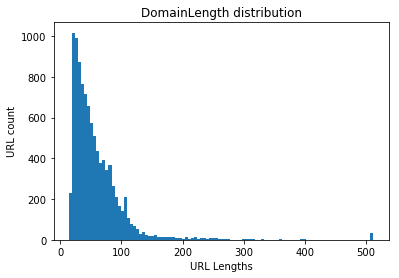

In [34]:
domainlengths=df["url"].apply(lambda x: len(x))
plt.hist(domainlengths,bins=100)
plt.xlabel('URL Lengths')
plt.ylabel('URL count')
plt.title('DomainLength distribution')
plt.show()

The above histogram shows that in this dataset majority of the URL have the 100 so i set a max_len to 100. Any URL vector that has less than 100 will be paaded with extra 0 

#### Embedding layer and need for it. 
In addition to the pre-processing I use an embedding layer. The Embedding can be implemented in mutliple ways and I experiment with the default Keras implementation of Tensorflow word2vec

One-hot encoded vectors are high-dimensional and sparse. Let’s assume that we are doing Natural Language Processing (NLP) and have a dictionary of 2000 words. This means that, when using one-hot encoding, each word will be represented by a vector containing 2000 integers. And 1999 of these integers are zeros. In a big dataset this approach is not computationally efficient.

The vectors of each embedding get updated while training the neural network. If you have seen the image at the top of this post you can see how similarities between words can be found in a multi-dimensional space. This allows us to visualize relationships between words, but also between everything that can be turned into a vector through an embedding layer

##### Additional verbose logging for the Deep learning models
The below method is used to print layers within the three individual netowrks implemented in this project. 

In [6]:
# GENERAL get layer dimensions for any model!
def print_layers_dims(model):
    l_layers = model.layers
    # Note None is ALWAYS batch_size
    for i in range(len(l_layers)):
        print(l_layers[i])
        print('Input Shape: ', l_layers[i].input_shape, 'Output Shape: ', l_layers[i].output_shape)


### <font color='blue'> Training and Evaluation </font>


The dataset is split for train and test samples

In [7]:
# Simple Cross-Validation: Split the data set into training and test data
X_train, X_test, target_train, target_test = model_selection.train_test_split(X, target, test_size=0.25, random_state=33)

#### <font color='blue'>Input and Output Layers of Neural Networks </font>

I would like to show what the input and output layers implemented in this project would look like.  The very first initial layer is always an input layer where you define the initial input shape (here initial 100 characters of the URL). 


Next is the Embedding layer that is built upon the Input layer. 

<img src="embeddedlayer.png">

This general process of "chaining" would continue...

<img src="chainlayer.png">

. until the output layer where the actual classification takes place. Since this project is about a binary classification task, a sigmoid activation function is used. Furthermore, since the target vector containing the labels is a binary 1D vector. In a multi-class scenario, the target vector would have needed to be one-hot encoded and the number of neurons would be n classes with a softmax activation function as an alternate option. 

Output layer (last fully connected layer)

output = Dense (1, activation='sigmoid', name='output')(<penultimate_layer>)


### <font color='blue'> Model 1 Simple LSTM </font>

LSTM or 1D convolutions can be used separately or together for the URL classification task. In any case before arriving to the output layer, it is very common to add a few fully connected hidden layers.  Finally, in every architecture the model has to be compiled while defining the optimizer and parameters such as learning rate to train the model in an iterative fashion as well as the loss function that quantifies how well the model is performing at each iteration. 

This is a simple one LSTM layer architecture which uses sigmoid as the activation function and Binary cross entropy for loss function. Dropout refers to ignoring units (i.e. neurons) during the training phase of certain set of neurons which is chosen at random. By “ignoring”, I mean these units are not considered during a particular forward or backward pass. This is done to prevent over-fitting. 

** <font color='Purple'>Model features: </font> **
1. **Activation function **: Sigmoid. 
2. **Loss Function** binary_crossentropy
3. **Number of Epochs** 10
4. **Optimizer Adam **: is an optimization algorithm that can used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.


### LSTM Networks

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer

http://www.bioinf.jku.at/publications/older/2604.pdf

#### Why we need an Optmizer and what is Adam Optimizer
Adam is an optimization algorithm that can used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data. Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.
Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance).

Specifically, the algorithm calculates an exponential moving average of the gradient and the squared gradient, and the parameters beta1 and beta2 control the decay rates of these moving averages.


#### What are loss Functions:
Loss functions are helpful to train a neural network. Given an input and a target, they calculate the loss, i.e difference between output and target variable.  Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. **Cross-entropy** loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0.



#### What is an Activation function
It is used to determine the output of neural network like yes or no. It maps the resulting values in between 0 to 1 or -1 to 1 etc. (depending upon the function).
The Activation Functions can be basically divided into 2 types-

1. Linear Activation Function

2. Non-linear Activation Functions

The main reason why we use <font color='blue'> sigmoid function </font> is because it exists between (0 to 1). Therefore, it is especially used for models where we have to predict the probability as an output.Since probability of anything exists only between the range of 0 and 1, sigmoid is the right choice

In [8]:
## Simple LSTM
def simple_lstm(max_len=100, emb_dim=32, max_vocab_len=100, lstm_output_size=32, W_reg=regularizers.l2(1e-4)):
    # Input
    main_input = Input(shape=(max_len,), dtype='int32', name='main_input')
    
    # Embedding layer
    emb = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len,
                dropout=0.2, W_regularizer=W_reg)(main_input) 

    
    # LSTM layer
    lstm = LSTM(lstm_output_size)(emb)
    lstm = Dropout(0.5)(lstm)
    
    # Output layer (last fully connected layer)
    output = Dense(1, activation='sigmoid', name='output')(lstm)

    # Compile model and define optimizer
    model = Model(input=[main_input], output=[output])
    
    sgd= SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [9]:
# Fit model and Cross-Validation, ARCHITECTURE 1 SIMPLE LSTM
nb_epoch = 10
batch_size = 32

model = simple_lstm()
model.fit(X_train, target_train, nb_epoch=nb_epoch, batch_size=batch_size)
loss, accuracy = model.evaluate(X_test, target_test, verbose=1)
print('\nFinal Cross-Validation Accuracy', accuracy, '\n')
#print_layers_dims(model)

Epoch 1/10
7498/7498 [==============================] - 46s 6ms/step - loss: 0.6317 - acc: 0.7439
Epoch 2/10
7498/7498 [==============================] - 46s 6ms/step - loss: 0.5339 - acc: 0.7559
Epoch 3/10
7498/7498 [==============================] - 45s 6ms/step - loss: 0.4896 - acc: 0.7634
Epoch 4/10
7498/7498 [==============================] - 47s 6ms/step - loss: 0.4501 - acc: 0.7870
Epoch 5/10
7498/7498 [==============================] - 46s 6ms/step - loss: 0.4319 - acc: 0.8130
Epoch 6/10
7498/7498 [==============================] - 44s 6ms/step - loss: 0.4160 - acc: 0.8244
Epoch 7/10
7498/7498 [==============================] - 43s 6ms/step - loss: 0.4077 - acc: 0.8354
Epoch 8/10
7498/7498 [==============================] - 44s 6ms/step - loss: 0.4014 - acc: 0.8394
Epoch 9/10
7498/7498 [==============================] - 46s 6ms/step - loss: 0.3948 - acc: 0.8420
Epoch 10/10
2500/2500 [==============================] - 3s 1ms/step

Final Cross-Validation Accuracy 0.836 



#### <font color='green'> Final Cross-Validation Accuracy 83.6% for 10 epochs and batch_size of 32</font>

Total input is 10,000 URL and sample training set is 7498. 


### <font color='green'> Model Summary </font>

The below step helps determine what are the layers in this model and how each of the laters are connected.

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 32)           3200      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 11,553
Trainable params: 11,553
Non-trainable params: 0
_________________________________________________________________


### Metrics for Model1

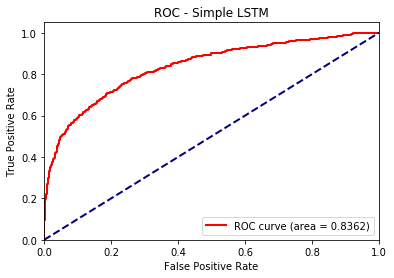

In [12]:
from sklearn import metrics
pred = model.predict(X_test)
#pred
fpr, tpr, thresholds = metrics.roc_curve(target_test, pred, pos_label=1)
auc_m = metrics.auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='red',lw=lw, label='ROC curve (area = %0.4f)' % auc_m)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Simple LSTM')
plt.legend(loc="lower right")
plt.show()


In [13]:
f1 = metrics.f1_score(target_test, pred>0.5)
f1
acc = metrics.accuracy_score(target_test, pred>0.5)
acc
print ("f1 = ", f1, "acc = ", acc, "auc=" , auc_m)

f1 =  0.570230607966 acc =  0.836 auc= 0.836162651608


### <font color='blue'> Model 2 Implementing Convolutional Neural Networks </font>

#### Intro to  Convolutional Neural Networks 

<img src="cnn.png">

There are four main operations in the ConvNet shown in Figure above:

Convolution

Non Linearity (ReLU) in my implementation I use ELU instead of ReLU

Pooling or Sub Sampling

Classification (Fully Connected Layer)

To prevent Overfitting I use a DropOutLayer. 

More info https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/


Each convolution layer is individually called and ELU is used as an activation function 
On the final dense later the activation function is sigmoid.  


In [29]:
def conv_fully(max_len=100, emb_dim=32, max_vocab_len=100, W_reg=regularizers.l2(1e-4)):
    # Input
    main_input = Input(shape=(max_len,), dtype='int32', name='main_input')
    # Embedding layer
    emb = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len,
                W_regularizer=W_reg)(main_input) 
    emb = Dropout(0.25)(emb)

    def sum_1d(X):
        return K.sum(X, axis=1)
    def get_conv_layer(emb, kernel_size=5, filters=256):
        # Conv layer
        conv = Convolution1D(kernel_size=kernel_size, filters=filters, \
                     border_mode='same')(emb)
        conv = ELU()(conv)

        conv = Lambda(sum_1d, output_shape=(filters,))(conv)
        #conv = BatchNormalization(mode=0)(conv)
        conv = Dropout(0.5)(conv)
        return conv
        
    # Multiple Conv Layers
    
    # calling custom conv function from above
    conv1 = get_conv_layer(emb, kernel_size=2, filters=256)
    conv2 = get_conv_layer(emb, kernel_size=3, filters=256)
    conv3 = get_conv_layer(emb, kernel_size=4, filters=256)
    conv4 = get_conv_layer(emb, kernel_size=5, filters=256)

    # Fully Connected Layers
    merged = concatenate([conv1,conv2,conv3,conv4], axis=1)

    hidden1 = Dense(1024)(merged)
    hidden1 = ELU()(hidden1)
    hidden1 = BatchNormalization(mode=0)(hidden1)
    hidden1 = Dropout(0.5)(hidden1)

    hidden2 = Dense(1024)(hidden1)
    hidden2 = ELU()(hidden2)
    hidden2 = BatchNormalization(mode=0)(hidden2)
    hidden2 = Dropout(0.5)(hidden2)
    
    # Output layer (last fully connected layer)
    output = Dense(1, activation='sigmoid', name='output')(hidden2)

    # Compile model and define optimizer
    model = Model(input=[main_input], output=[output])
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Model Characteristics
1. 4 Fully connected layers with 2 dense layers.  
2. Activation function used is **sigmoid** on the final dense later.
3. Optimizer in used is **Adam**.
4. Loss function in use **Binary Cross entropy**. 
5. With 5 Epocs and a batch size of 32. 



#### What are loss Functions:
Loss functions are helpful to train a neural network. Given an input and a target, they calculate the loss, i.e difference between output and target variable.  Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0.

In [30]:
# Fit model and Cross-Validation, ARCHITECTURE 3 CONV + FULLY CONNECTED
epochs = 10
batch_size = 32

model = conv_fully()
model.fit(X_train, target_train, epochs=epochs, batch_size=batch_size)
loss, accuracy = model.evaluate(X_test, target_test, verbose=1)

print('\nFinal Cross-Validation Accuracy', accuracy, '\n')
#print_layers_dims(model)

Epoch 1/10
7498/7498 [==============================] - 23s 3ms/step - loss: 0.8936 - acc: 0.5662
Epoch 2/10
7498/7498 [==============================] - 20s 3ms/step - loss: 0.7131 - acc: 0.6671
Epoch 3/10
7498/7498 [==============================] - 21s 3ms/step - loss: 0.6481 - acc: 0.7029
Epoch 4/10
7498/7498 [==============================] - 21s 3ms/step - loss: 0.5999 - acc: 0.7383
Epoch 5/10
7498/7498 [==============================] - 20s 3ms/step - loss: 0.5759 - acc: 0.7475
Epoch 6/10
7498/7498 [==============================] - 21s 3ms/step - loss: 0.5601 - acc: 0.7585
Epoch 7/10
7498/7498 [==============================] - 21s 3ms/step - loss: 0.5399 - acc: 0.7706
Epoch 8/10
7498/7498 [==============================] - 20s 3ms/step - loss: 0.5441 - acc: 0.7697
Epoch 9/10
7498/7498 [==============================] - 19s 3ms/step - loss: 0.5203 - acc: 0.7762
Epoch 10/10
2500/2500 [==============================] - 2s 758us/step

Final Cross-Validation Accuracy 0.8108 



#### <font color='green'> Final Cross-Validation Accuracy 81.08% for 10 epoch and batch_size of 32</font>

Total input is 10,000 URL and sample training set is 7498. 


### <font color='green'> Model Summary </font>
The below step helps determine what are the layers in this model and how each of the laters are connected.

In [31]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 32)      3200        main_input[0][0]                 
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 100, 32)      0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 100, 256)     16640       dropout_13[0][0]                 
__________________________________________________________________________________________________
conv1d_9 (

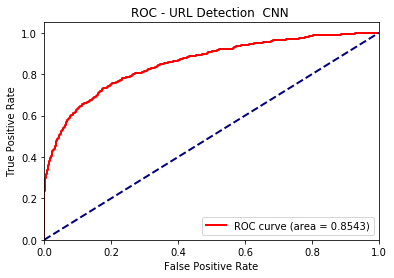

In [32]:
from sklearn import metrics
pred = model.predict(X_test)
#pred
auc_m = metrics.auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='red',lw=lw, label='ROC curve (area = %0.4f)' % auc_m)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - URL Detection  CNN ')
plt.legend(loc="lower right")
plt.show()

In [33]:
f1 = metrics.f1_score(target_test, pred>0.5)
f1
acc = metrics.accuracy_score(target_test, pred>0.5)
acc
print ("f1 = ", f1, "acc = ", acc, "auc=" , auc_m)

f1 =  0.416769420469 acc =  0.8108 auc= 0.854326040392


**Save Model to Disk**

The below function and stpes help save model to disk and use later against a diff dataset for test or verificaiton 

In [71]:
# GENERAL save model to disk function!
def save_model(fileModelJSON,fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    #have h5py installed
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        json.dump(json_string, f)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save_weights(fileWeights)
    

In [72]:
model_name = "deeplearning_1DConv"
save_model(path + model_name + ".json", path + model_name + ".h5")
#model = load_model(path + model_name + ".json", path + model_name + ".h5")
#print_layers_dims(model)

### <font color='blue'> Model 3  Implementing Bi-directional LSTM and CNN <font>

Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems. It involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side, then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second.
The use of bidirectional LSTMs may not make sense for all sequence prediction problems, but can offer some benefit in terms of better results to those domains where it is appropriate.


In [21]:
from keras.layers import Layer,initializers,Flatten,RepeatVector,Permute
from keras.layers.merge import Multiply
    
def binarize(x, sz=71):
    return tf.to_float(tf.one_hot(x, sz, on_value=1, off_value=0, axis=-1))


def binarize_outshape(in_shape):
    return in_shape[0], in_shape[1], 71
filter_length = [5, 3, 3]
nb_filter = [128, 196, 256 ]
pool_length = 2

# sentence input
in_sentence = Input(shape=(max_len,), dtype='int64')
# char indices to one hot matrix, 1D sequence to 2D 
embedded = Lambda(binarize, output_shape=binarize_outshape)(in_sentence)
# embedded: encodes sentence
for i in range(len(nb_filter)):
    embedded = Conv1D(filters=nb_filter[i],
                      kernel_size=filter_length[i],
                      padding='valid',
                      activation='relu',
                      kernel_initializer='glorot_normal',
                      strides=1)(embedded)
    embedded = Dropout(0.2)(embedded)
    embedded = MaxPooling1D(pool_size=pool_length)(embedded)
bi_lstm_sent = \
    Bidirectional(LSTM(100, return_sequences=True, dropout=0.15, recurrent_dropout=0.15, implementation=0))(embedded)


    
# compute importance for each step
attention = TimeDistributed(Dense(1, activation='tanh'))(bi_lstm_sent) 
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(200)(attention)
attention = Permute([2, 1])(attention)    
    

# apply the attention 
sent_representation = Multiply()([bi_lstm_sent, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=1))(sent_representation)
    
    
# sent_encode = merge([forward_sent, backward_sent], mode='concat', concat_axis=-1)
sent_encode = Dropout(0.4)(sent_representation)
sent_encode = Activation("relu")(sent_encode)
sent_encode = Dense(units=2)(sent_encode)
sent_encode = Activation("softmax")(sent_encode)

# sentence encoder
model = Model(inputs=in_sentence, outputs=sent_encode)

model.summary()
#model = utils.make_parallel(model, 2)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 100, 71)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 96, 128)      45568       lambda_5[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 96, 128)      0           conv1d_5[0][0]                   
__________________________________________________________________________________________________
max_poolin

#### Model features
1. 3 convolution layers and one Bi-directional LSTM later 
2. Each layer uses a combination of softmax and relu activation function
3. Optimizer in used is Adam.
4. Loss function implemented in this model is sparse categorical crossentropy. 
5. With 5 Epocs and a batch size of 32, Final Cross-Validation Accuracy 84.56



In [23]:
adam = Adam()
#model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['sparse_categorical_accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [24]:
hist=model.fit(X_train, target_train, epochs=10, batch_size=32)
loss, accuracy = model.evaluate(X_test, target_test, verbose=1)

print('\nFinal Cross-Validation Accuracy', accuracy, '\n')


Epoch 1/10
7498/7498 [==============================] - 23s 3ms/step - loss: 0.5131 - acc: 0.7687
Epoch 2/10
7498/7498 [==============================] - 23s 3ms/step - loss: 0.4384 - acc: 0.8035
Epoch 3/10
7498/7498 [==============================] - 23s 3ms/step - loss: 0.3715 - acc: 0.8434
Epoch 4/10
7498/7498 [==============================] - 22s 3ms/step - loss: 0.3071 - acc: 0.8821
Epoch 5/10
7498/7498 [==============================] - 22s 3ms/step - loss: 0.2598 - acc: 0.9016
Epoch 6/10
7498/7498 [==============================] - 22s 3ms/step - loss: 0.2118 - acc: 0.9234
Epoch 7/10
7498/7498 [==============================] - 21s 3ms/step - loss: 0.1894 - acc: 0.9336
Epoch 8/10
7498/7498 [==============================] - 22s 3ms/step - loss: 0.1559 - acc: 0.9463
Epoch 9/10
7498/7498 [==============================] - 22s 3ms/step - loss: 0.1303 - acc: 0.9561
Epoch 10/10
2500/2500 [==============================] - 2s 881us/step

Final Cross-Validation Accuracy 0.8368 



##### <font color='green'> Final Cross-Validation Accuracy 84.56% for 10 epochs and batch_size of 32</font>

Total input is 10,000 URL and sample training set is 7498. 

### <font color='green'> Model Summary </font>
The below step helps determine what are the layers in this model and how each of the laters are connected.

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 100, 71)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 96, 128)      45568       lambda_5[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 96, 128)      0           conv1d_5[0][0]                   
__________________________________________________________________________________________________
max_poolin

### <font color='blue'> Results </font>

The ROC curve is created by plotting the **true positive rate (TPR) ** against the **false positive rate (FPR)** at various threshold settings. The true-positive rate is also known as **sensitivity, recall or probability  of detection ** in machine learning. The false-positive rate is also known as the  ** fall-out or probability of false alarm ** and can be calculated as (1 − specificity)
**ROC analysis ** provides tools to select possibly optimal models and to discard suboptimal ones independently from (and prior to specifying) the cost context or the class distribution. ROC analysis is related in a direct and natural way to cost/benefit analysis of diagnostic decision making.

The below verification is done on the **BiDirectional LSTM** model and the ROC curve indicates a higher false positive rate.

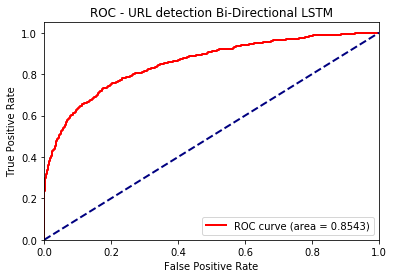

In [26]:
from sklearn import metrics
pred = model.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(target_test, pred[:,1], pos_label=1)
auc_m = metrics.auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='red',lw=lw, label='ROC curve (area = %0.4f)' % auc_m)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - URL detection Bi-Directional LSTM')
plt.legend(loc="lower right")
plt.show()

In addition to the above we also use the F1 score, AUC and accuracy metrics to determine the efficiency of the model implemented

#### F-score

In statistical analysis of binary classification, the F1 score (also F-score or F-measure) is a measure of a test's accuracy. It considers both the **precision p** and the **recall r** of the test to compute the score: 

**Precision** is the number of correct positive results divided by the number of all positive results returned by the classifier, 

**Recall** is the number of correct positive results divided by the number of all relevant samples (all samples that should have been identified as positive). 

The **F1 score** is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.

<img src="f.svg">

#### Accuracy and Precision

**Precision** is a description of random errors, a measure of statistical variability.

**Accuracy** has two definitions:

  * More commonly, it is a description of systematic errors, a measure of statistical bias; as these cause a difference between a result and a "true" value, ISO calls this trueness.

  * Alternatively, ISO defines accuracy as describing a combination of both types of observational error above (random and systematic), so high accuracy requires both high precision and high trueness.

In simplest terms, given a set of data points from repeated measurements of the same quantity, the set can be said to be precise if the values are close to each other, while the set can be said to be accurate if their average is close to the true value of the quantity being measured. The two concepts are independent of each other, so a particular set of data can be said to be either accurate, or precise, or both, or neither.

<img src="roc.svg">

In [27]:
from sklearn.metrics import confusion_matrix
f1 = metrics.f1_score(target_test, pred[:,1]>0.5)
acc = metrics.accuracy_score(target_test, pred[:,1]>0.5)
print ("f1 = ", f1, "acc = ", acc, "auc=" , auc_m)
#print ("test confusion matrix\n" , confusion_matrix(target_test, pred[:,1]>0.5))

f1 =  0.651282051282 acc =  0.8368 auc= 0.854326040392


With the latest model the 

  * **F1 score is  <font color='green'>0.65 </font> **
  * **Accuracy is  <font color='green'>84.56 </font> **
  * **AUC is <font color='green'>0.86</font> **

### <font color='blue'> Prediction </font>
In contrast to more traditional Machine Learning, where preprocessing and/or feture engineering can be quite tedious to transform a new URL into feature vector space, it's quite straight forward in the approach proposed here.

** <font color='purple'>Steps to test the model </font>**
1.	Convert raw URL string in list of lists where characters that are contained in "printable" are stored encoded as integer.

2.	Cut URL string at max_len or pad with zeros if shorter

3.	Make a new prediction with trained model


In [38]:
X_predict_o = ['wikipedia.com',
             'google.com',
             'pakistanifacebookforever.com',
             'www.radsport-voggel.de',
             'ahrenhei.without-transfer.ru',
             'www.itidea.it',
             'stackoverflow.com',
             'dzone.com',
            'keras.io',
             'www.tiktik.co.il']

In [32]:
# Initial Data Preparation URL

# Step 1: Convert raw URL string in list of lists where characters that are contained in "printable" are stored encoded as integer 
url_int_tokens = [[printable.index(x) + 1 for x in url if x in printable] for url in X_predict_o]

# Step 2: Cut URL string at max_len or pad with zeros if shorter
max_len=100
X1 = sequence.pad_sequences(url_int_tokens, maxlen=max_len)
#print(X1)
# Step 3: Extract labels form df to numpy array
target = np.array(df.malicious)

print('Matrix dimensions of X: ', X.shape, 'Vector dimension of target: ', target.shape)

Matrix dimensions of X:  (1, 100) Vector dimension of target:  (9998,)


In [31]:
prd1 = model.predict(X1)
dfn = pd.DataFrame(columns=('site', 'score', 'prediction'))
pd.set_option('max_colwidth',500)    
for i in range(len(X_predict_o)):
    a = [X_predict_o[i],  prd1[i,1],prd1[i,1]>0.5 ]
    dfn.loc[i] = a
dfn


,site,score,prediction
0,wikipedia.com,0.007914,False
1,google.com,0.007872,False
2,pakistanifacebookforever.com,0.064834,False
3,www.radsport-voggel.de,0.008443,False
4,ahrenhei.without-transfer.ru,0.042111,False
5,www.itidea.it,0.008915,False
6,stackoverflow.com,0.009805,False
7,dzone.com,0.007869,False
8,keras.io,0.007861,False
9,www.tiktik.co.il,0.009828,False


** As noted from above the model is successfully able to predict for the given test test ** 

### <font color='blue'> References:</font>

Malicious URL Detection using Machine Learning
   
   https://arxiv.org/pdf/1701.07179.pdf

Learning a URL Representation with Deep Learning for Malicious URL Detection

   https://arxiv.org/pdf/1802.03162.pdf

Expose A Character-Level Convolutional Neural Network with Embedding For Detecting Malicious URLs

  https://arxiv.org/pdf/1702.08568.pdf

Word2Vec Embedding
    
  https://www.tensorflow.org/tutorials/word2vec

Activation Function
 
   https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6

Convolution Neural Networks

   https://wiki.tum.de/display/lfdv/Recurrent+Neural+Networks+-+Combination+of+RNN+and+CNN
   
   https://github.com/nikbearbrown/NEU_COE/tree/master/Deep_Learning/CNNs
   
RNN

  https://github.com/nikbearbrown/NEU_COE/tree/master/Deep_Learning/RNNs/ 
    

LSTM

  https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

Embedding Layers
 
 https://towardsdatascience.com/deep-learning-4-embedding-layers-f9a02d55ac12/
    
 Metrics
 
   https://en.wikipedia.org/wiki/F1_score
   
   https://en.wikipedia.org/wiki/Accuracy_and_precision

### <font color='blue'> Licenses </font>

The code in the document by Lakshmi Peri is licensed under the MIT License https://opensource.org/licenses/MIT

This work is licensed under the Creative Commons Attribution 3.0 United States License. To view a copy of this license, visit http://creativecommons.org/licenses/by/3.0/us/ or send a letter to Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.